# <center> **Практика по оптимизации гиперпараметров модели**

## 1. Задание

Наша практика будет основана на соревновании [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse) (Прогнозирование биологического ответа).

<div style="border: 2px solid #000000ff; padding: 20px;">
Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).</div>

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 
- Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
- Остальные столбцы D1-D1776 представляют собой молекулярные **дескрипторы** — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать **F1-score**.

Необходимо обучить две модели: **логистическую регрессию** и **случайный лес**. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать **все четыре метода** (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

## 2. Загрузка и предобработка данных

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Библиотеки для оптимизации
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials
import optuna


# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook', style="whitegrid", palette="Set2")
%matplotlib inline

In [2]:
# Загрузка данных
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Посмотрим размерность
data.shape

(3751, 1777)

In [4]:
# Проверим что нет пропусков
data.isnull().sum().sum()

0

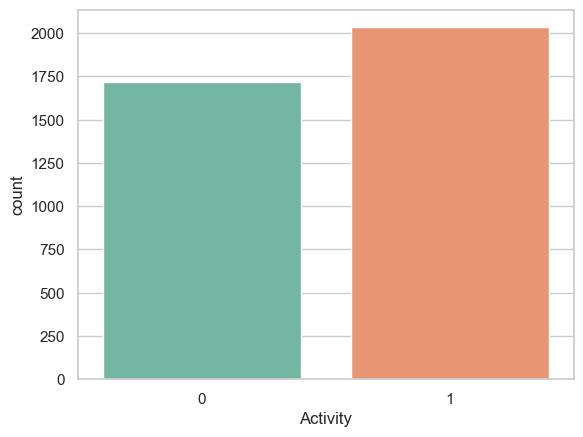

In [5]:
# Посмотрим на сбалансированность классов
sns.countplot(data=data, x='Activity', hue='Activity', legend=False);

Классы сбалансированы, разница в распределении менее 5%.

In [6]:
# Зафиксируем random_state
random_state = 15

# Создаем матрицу наблюдений X и вектор ответов y
X = data.drop(['Activity'], axis=1)
y = data['Activity']

# Разделяем выборку на тренировочную и тестовую
# в соотношении 70/30 - так как данных не очень много
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=random_state, test_size = 0.3
)

## 3. Обучение базовых моделей

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

### Логистическая регрессия

In [7]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000, random_state=random_state)
# Обучаем модель
log_reg.fit(X_train, y_train)
# Выводим метрики
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('F1 на тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 на тренировочной выборке: 0.90
F1 на тестовой выборке: 0.78


### Случайный лес

In [8]:
# Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=random_state)
# Обучаем модель
rf.fit(X_train, y_train)
# Выводим значения метрики 
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print('F1 на тренировочной выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 на тренировочной выборке: 1.00
F1 на тестовой выборке: 0.82


## 4. Базовая оптимизация гиперпараметров модели

### **GridSearchCV**

#### Логистическая регрессия

In [9]:
# Задаю параметры
param_grid = [
    # Без регуляризации
    {'penalty': [None],
     'solver': ['lbfgs', 'sag', 'newton-cg']},
     
    # L2 регуляризация
    {'penalty': ['l2'],
     'solver': ['lbfgs', 'liblinear', 'sag', 'newton-cg'],
     'C': list(np.linspace(0.01, 1, 5))},
     
    # L1 регуляризация
    {'penalty': ['l1'],
     'solver': ['liblinear', 'saga'],
     'C': list(np.linspace(0.01, 1, 5))}
]

# Создаем объект GridSearchCV для поиска по сетке
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=1000),
    param_grid=param_grid, 
    cv=3, # 3-кратная кросс-валидация для скорости
    n_jobs = -1,
    scoring='f1', # Целевая метрика F1
    verbose=1  # Добавила прогресс бар, чтобы понимать что не зависла
)

# Обучаем модель с подбором гиперпараметров и замеряем время
%time grid_search.fit(X_train, y_train) 
# Выводим результаты
print('F1 на тренировочной выборке: {:.2f}'.format(grid_search.score(X_train, y_train)))
print('F1 на тестовой выборке: {:.2f}'.format(grid_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Fitting 3 folds for each of 33 candidates, totalling 99 fits
CPU times: total: 1.95 s
Wall time: 4min 35s
F1 на тренировочной выборке: 0.82
F1 на тестовой выборке: 0.79
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


Тестовую метрику удалось немного улучшить (F1 - 0.79, против 0.78 в базовой). Также было уменьшено переобучение F1 на тренировочной выборке снизился с 0.90 до 0.82. Перебор гиперпараметров занял значительное время (5 минут).

#### Случайный лес

In [10]:
# Задаю параметры
param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': list(range(100, 500, 100)),
    'min_samples_leaf': [5],
    'max_depth': list(range(10, 30, 10)),
    # Так как много признаков, для уменьшения переобучения
    'max_features': ['sqrt', 'log2']
}

# Создаем объект GridSearchCV для поиска по сетке
grid_search = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_grid=param_grid, 
    cv=3,
    n_jobs = -1,
    scoring='f1',
    verbose=1
)

# Обучаем модель с подбором гиперпараметров и замеряем время
%time grid_search.fit(X_train, y_train)
# Выводим результаты
print('F1 на тренировочной выборке: {:.2f}'.format(grid_search.score(X_train, y_train)))
print('F1 на тестовой выборке: {:.2f}'.format(grid_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
CPU times: total: 3.16 s
Wall time: 50.9 s
F1 на тренировочной выборке: 0.95
F1 на тестовой выборке: 0.82
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200}


Лучший результат у модели с значением целевой метрики F1 - 0.82 для теста, и 0.95 для тренировочной выборки. Т.е. благодаря GridSearch мы смогли уменьшить переобучение одновременно сохранив показатели для тестовой метрики.

-------------

Сравнивая модели, случайный лес демонстрирует лучшие результаты по сравнению с логистической регрессией. Кроме того случайный лес обучается быстрее при том же количестве моделей, что и в регрессии. Учитывая это преимущество и потенциал для дальнейшей оптимизации, все последующие эксперименты по улучшению метрик были сосредоточены исключительно на случайном лесе. Логистическая регрессия, показавшая ограниченную эффективность для данной задачи, была исключена из дальнейшего рассмотрения.

### **RandomizedSearchCV**

In [11]:
# Параметры
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': list(range(100, 500, 10)),
    'min_samples_leaf': list(range(3, 7, 1)),
    'max_depth': list(range(10, 30, 5)),
    'max_features': ['sqrt', 'log2']
}

# Создаем объект RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_distributions=param_distributions, 
    cv=3, 
    n_iter = 10,
    n_jobs = -1,
    scoring='f1',
    verbose=2
)

# Обучаем модель, выводим метрики
%time random_search.fit(X_train, y_train) 
print('F1 на тренировочной выборке: {:.2f}'.format(random_search.score(X_train, y_train)))
print('F1 на тестовой выборке: {:.2f}'.format(random_search.score(X_test, y_test)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: total: 4.8 s
Wall time: 19 s
F1 на тренировочной выборке: 0.95
F1 на тестовой выборке: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 340, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}


RandomizedSearchCV показал те же результаты что и GridSearchCV. Тем не менее он показал значительное улучшение скорости (код выполняется быстрее в 2 раза). Попробуем улучшить метрики продвинутыми методами оптимизации.

## 5. Продвинутая оптимизация гиперпараметров модели.

### **Hyperopt**

In [12]:
# Задаю пространство поиска гиперпараметров
criterion_opt = ['gini', 'entropy']
max_features_opt = ['sqrt', 'log2']
space={
    'criterion': hp.choice('criterion', criterion_opt),
    'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
    'max_depth' : hp.quniform('max_depth', 10, 30, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1),
    'max_features': hp.choice('max_features', max_features_opt)
}

# Функция для оптимизации Hyperopt
def hyperopt(params, cv=3, X=X_train, y=y_train, random_state=random_state):
    params = {
        'criterion': params['criterion'],
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']), 
        'min_samples_leaf': int(params['min_samples_leaf']),
        'max_features': params['max_features']
    }
  
    # Задаем модель с нашими параметрами
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # Обучаем модель через кросс-валидацию
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # Возвращаем метрику со знаком минус
    return -score

# Для логирования результатов
trials = Trials()

In [13]:
%%time
# Начинаем подбор гиперпараметров
best=fmin(
    hyperopt, 
    space=space,
    max_evals=20,
    trials=trials,
    rstate=np.random.default_rng(random_state) # фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

TPE is being used as the default algorithm.


100%|██████████| 20/20 [00:48<00:00,  2.40s/trial, best loss: -0.8042069660083134]
Наилучшие значения гиперпараметров {'criterion': 1, 'max_depth': 20.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'n_estimators': 262.0}
CPU times: total: 1.09 s
Wall time: 48.1 s


In [14]:
# Создаю модель на лучших параметрах
model = ensemble.RandomForestClassifier(
    criterion=criterion_opt[best['criterion']],
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf']),
    max_features=max_features_opt[best['max_features']]
)
# Обучение
model.fit(X_train, y_train)
# Предсказание и метрики
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.97
f1_score на тестовом наборе: 0.83


Hyperopt позволил достичь целевого значения F1-score 0.83 на тестовой выборке, что выше на 0.01 чем в RandomizedSearch и GridSearch.

### **Optuna**

In [ ]:
# Целевая функция для Optuna
def optuna_rf(trial, X=X_train, y=y_train, cv=3, scoring="f1"):

  # Задаем пространства поиска гиперпараметров
  criterion = trial.suggest_categorical('criterion', criterion_opt)
  n_estimators = trial.suggest_int('n_estimators', 100, 300, step=1)
  max_depth = trial.suggest_int('max_depth', 10, 30, step=1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 4, 7, step=1)
  max_features = trial.suggest_categorical('max_features', max_features_opt)

  # Создаем модель
  model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=n_estimators,
    criterion=criterion,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features
)
  # Кросс-валидация сама обучит модель
  score = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1).mean()
  # Возвращает целевую метрику
  return score

In [35]:
%%time
# Cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-11-28 05:10:29,569] A new study created in memory with name: RandomForestClassifier
[I 2025-11-28 05:10:31,906] Trial 0 finished with value: 0.7923761815520396 and parameters: {'criterion': 'gini', 'n_estimators': 232, 'max_depth': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7923761815520396.
[I 2025-11-28 05:10:32,875] Trial 1 finished with value: 0.7751697475776704 and parameters: {'criterion': 'gini', 'n_estimators': 186, 'max_depth': 14, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.7923761815520396.
[I 2025-11-28 05:10:33,609] Trial 2 finished with value: 0.7864478182192275 and parameters: {'criterion': 'gini', 'n_estimators': 110, 'max_depth': 30, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.7923761815520396.
[I 2025-11-28 05:10:34,894] Trial 3 finished with value: 0.7698545368484465 and parameters: {'criterion': 'gini', 'n_estimators': 201, 'max_depth': 15, 'min_samples

CPU times: total: 1.11 s
Wall time: 52.7 s


In [36]:
# Обучаю модель на лучших параметрах, вывожу метрики
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'criterion': 'entropy', 'n_estimators': 262, 'max_depth': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
f1_score на обучающем наборе: 0.97
f1_score на тестовом наборе: 0.83


F1-score на тестовой выборке: 0.83, на тренировочной выборке: 0.97, такие же как у Hyperopt.

----------

RandomizedSearchCV, Hyperopt и RandomizedSearch показали довольно хорошие результаты, при небольшом количестве времени получены примерно одинаковые показатели. В дальнейшем для улучшения модели на мой взгляд надо вводить более строгие ограничения в глубину деревьев и увеличивать количество листов, что повлияет на качество метрик на тестовой выборке, однако уменьшит переобучение моделей.